In [7]:
import os
import requests
import json
from pathlib import Path
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import io

def get_images_from_folders(base_path):
    """
    Obtiene todas las imágenes y sus etiquetas basadas en la estructura de carpetas
    
    Args:
        base_path (str): Ruta base que contiene las carpetas '0' y '1'
    
    Returns:
        list: Lista de tuplas (ruta_imagen, etiqueta)
    """
    image_data = []
    valid_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp'}
    
    # Procesar carpeta '0' (No Cancer)
    no_cancer_path = Path(base_path) / '0'
    if no_cancer_path.exists():
        for img_path in no_cancer_path.iterdir():
            if img_path.is_file() and img_path.suffix.lower() in valid_extensions:
                image_data.append((img_path, 0))
    
    # Procesar carpeta '1' (Cancer)
    cancer_path = Path(base_path) / '1'
    if cancer_path.exists():
        for img_path in cancer_path.iterdir():
            if img_path.is_file() and img_path.suffix.lower() in valid_extensions:
                image_data.append((img_path, 1))
    
    return image_data

def process_image(image_path):
    """
    Procesa la imagen y la convierte al formato requerido
    """
    # Abrir y redimensionar la imagen
    img = Image.open(image_path)
    img = img.resize((50, 50))  # Asegúrate que este tamaño coincida con el esperado por tu modelo
    
    # Convertir la imagen a bytes
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format=img.format if img.format else 'PNG')
    img_byte_arr = img_byte_arr.getvalue()
    
    return img_byte_arr

def test_local_api(base_path):
    """
    Prueba la API local con imágenes organizadas en carpetas por clase
    """
    # URL de la API local
    api_url = "http://localhost:5000/predict_image"  # Endpoint modificado para recibir archivos
    
    # Obtener todas las imágenes y sus etiquetas
    image_data = get_images_from_folders(base_path)
    
    # Listas para almacenar resultados
    y_true = []
    y_pred = []
    file_names = []
    confidences = []
    
    total_images = len(image_data)
    for idx, (image_path, true_label) in enumerate(image_data, 1):
        print(f"\nProcesando imagen {idx}/{total_images}: {image_path.name}")
        print(f"Etiqueta real: {'Cancer' if true_label == 1 else 'No Cancer'}")
        
        try:
            # Procesar la imagen
            img_bytes = process_image(image_path)
            
            # Preparar los datos para la petición
            files = {
                'file': (image_path.name, img_bytes, 'image/png')
            }
            
            # Hacer la petición POST a la API
            response = requests.post(api_url, files=files)
            
            # Verificar si la petición fue exitosa
            if response.status_code == 200:
                result = response.json()
                prediction = 1 if result['prediction'] == "Cancer" else 0
                confidence = result['confidence']
                
                y_true.append(true_label)
                y_pred.append(prediction)
                file_names.append(image_path.name)
                confidences.append(confidence)
                
                print(f"Predicción: {result['prediction']}")
                print(f"Confianza: {confidence:.2%}")
                
                # Indicador visual de acierto/error
                if prediction == true_label:
                    print("✅ Predicción correcta")
                else:
                    print("❌ Predicción incorrecta")
                
            else:
                print(f"Error en la petición: {response.status_code}")
                print(f"Mensaje: {response.text}")
                
        except Exception as e:
            print(f"Error al procesar la imagen: {str(e)}")
    
    return np.array(y_true), np.array(y_pred), file_names, confidences

def plot_results(y_true, y_pred, file_names, confidences):
    """
    Genera y muestra la matriz de confusión y métricas de evaluación
    """
    # 1. Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Cancer', 'Cancer'],
                yticklabels=['No Cancer', 'Cancer'])
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.savefig('confusion_matrix.png')
    plt.close()
    
    # 2. Imprimir métricas detalladas
    print("\n=== Reporte de Clasificación ===")
    print(classification_report(y_true, y_pred, target_names=['No Cancer', 'Cancer']))
    
    # 3. Estadísticas generales
    total = len(y_true)
    correct = sum(y_true == y_pred)
    accuracy = correct / total
    
    print("\n=== Estadísticas Generales ===")
    print(f"Total de imágenes procesadas: {total}")
    print(f"Predicciones correctas: {correct}")
    print(f"Predicciones incorrectas: {total - correct}")
    print(f"Precisión global: {accuracy:.2%}")
    print(f"Confianza promedio: {np.mean(confidences):.2%}")
    
    # 4. Casos incorrectos
    print("\n=== Casos Incorrectos ===")
    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            true_label = 'Cancer' if y_true[i] == 1 else 'No Cancer'
            pred_label = 'Cancer' if y_pred[i] == 1 else 'No Cancer'
            print(f"\nArchivo: {file_names[i]}")
            print(f"  Valor real: {true_label}")
            print(f"  Predicción: {pred_label}")
            print(f"  Confianza: {confidences[i]:.2%}")

if __name__ == "__main__":
    # Ruta a la carpeta base que contiene las subcarpetas '0' y '1'
    base_path = "C:/Users/willi/Desktop/prediction_breast_cancer/imagenes_pruebas"
    
    # Verificar que la ruta existe
    if not os.path.exists(base_path):
        print(f"Error: La ruta {base_path} no existe")
    else:
        # Ejecutar las pruebas
        print(f"Iniciando pruebas con imágenes en: {base_path}")
        y_true, y_pred, file_names, confidences = test_local_api(base_path)
        
        # Generar y mostrar resultados
        plot_results(y_true, y_pred, file_names, confidences)

Iniciando pruebas con imágenes en: C:/Users/willi/Desktop/prediction_breast_cancer/imagenes_pruebas

Procesando imagen 1/2016: 13404_idx5_x1001_y1351_class0.png
Etiqueta real: No Cancer
Predicción: No Cancer
Confianza: 96.32%
✅ Predicción correcta

Procesando imagen 2/2016: 13404_idx5_x1001_y1601_class0.png
Etiqueta real: No Cancer
Predicción: No Cancer
Confianza: 98.21%
✅ Predicción correcta

Procesando imagen 3/2016: 13404_idx5_x1001_y1651_class0.png
Etiqueta real: No Cancer
Predicción: No Cancer
Confianza: 66.09%
✅ Predicción correcta

Procesando imagen 4/2016: 13404_idx5_x1001_y2901_class0.png
Etiqueta real: No Cancer
Predicción: No Cancer
Confianza: 99.27%
✅ Predicción correcta

Procesando imagen 5/2016: 13404_idx5_x101_y2301_class0.png
Etiqueta real: No Cancer
Predicción: No Cancer
Confianza: 94.47%
✅ Predicción correcta

Procesando imagen 6/2016: 13404_idx5_x101_y2351_class0.png
Etiqueta real: No Cancer
Predicción: No Cancer
Confianza: 96.19%
✅ Predicción correcta

Procesando im

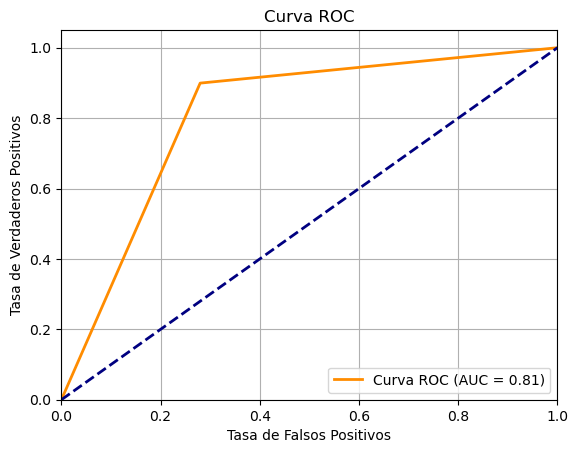

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Datos de entrada
# Verdaderos positivos y negativos
TP_cancer = 778  # Verdaderos positivos
FP_cancer = 87   # Falsos negativos
TN_no_cancer = 829  # Verdaderos negativos
FN_no_cancer = 322   # Falsos positivos

# Calculamos TPR y FPR
TPR = TP_cancer / (TP_cancer + FP_cancer)  # Sensibilidad
FPR = FN_no_cancer / (FN_no_cancer + TN_no_cancer)  # Falsos positivos

# Generamos los valores de TPR y FPR para la curva ROC
# Aquí crearemos una serie de umbrales, pero con los datos que tenemos, la curva será bastante simple.
y_true = [1] * (TP_cancer + FP_cancer) + [0] * (TN_no_cancer + FN_no_cancer)
y_scores = [1] * TP_cancer + [0] * FP_cancer + [0] * TN_no_cancer + [1] * FN_no_cancer

# Calculamos FPR y TPR
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Calculamos el área bajo la curva (AUC)
roc_auc = auc(fpr, tpr)

# Dibujamos la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()
